In [46]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kstest
import scipy.stats as st

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [47]:
sns.set()
matplotlib.rcParams['figure.figsize'] = (12, 7)
pd.set_option('display.float_format','{:.4f}'.format)

# KURS AKCJI TSMC (daily)

[*********************100%***********************]  1 of 1 completed


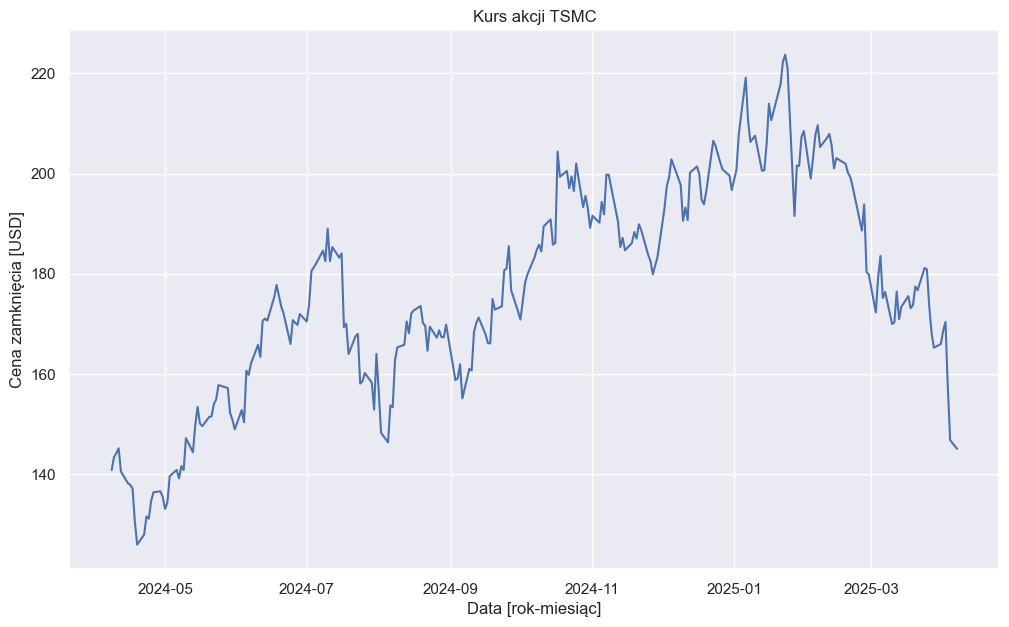

In [48]:
tsmc_data = yf.download('TSM', period = '1y')
tsmc_data = tsmc_data['Close']

plt.plot(tsmc_data)
plt.title('Kurs akcji TSMC')
plt.ylabel('Cena zamknięcia [USD]')
plt.xlabel('Data [rok-miesiąc]')
plt.grid(True)
plt.show()

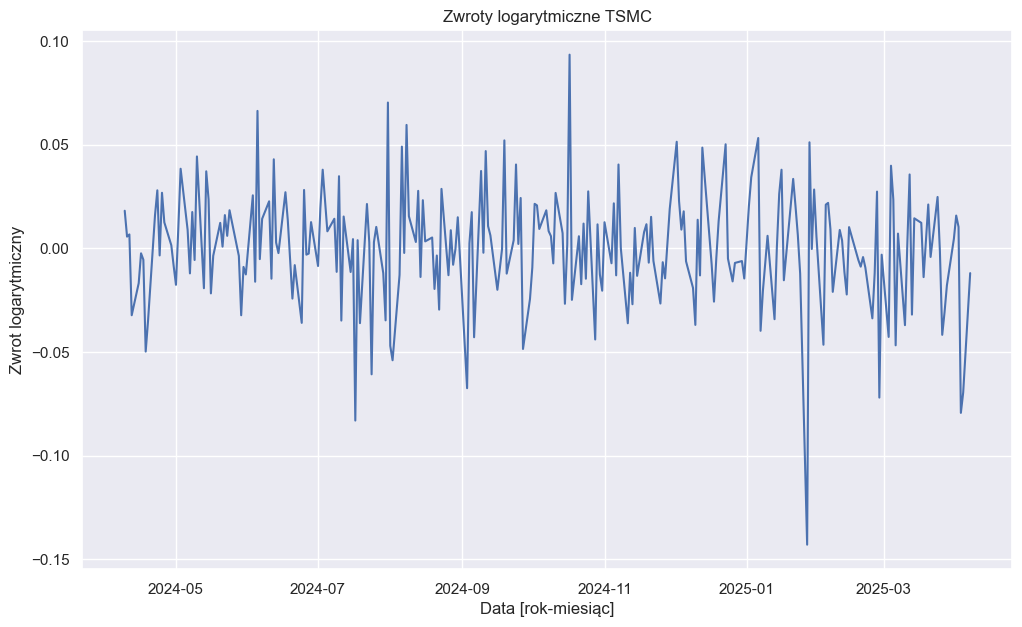

In [49]:
log_returns = np.log(tsmc_data / tsmc_data.shift(1)).dropna()

plt.plot(log_returns)
plt.title('Zwroty logarytmiczne TSMC')
plt.ylabel('Zwrot logarytmiczny')
plt.xlabel('Data [rok-miesiąc]')
plt.grid(True)
plt.show()


In [50]:
def adf_test(x, alpha=0.05):
    x = x.dropna()
    p_val = []
    is_stationary = []
    trend = ['Stała', 'Linia', 'Parabola', 'Brak']
    trends = ['c', 'ct', 'ctt', 'n']

    for i in trends:
        result = adfuller(x, regression=i, autolag='AIC')
        p = result[1]
        p_val.append(p)
        if p < alpha:
            is_stationary.append('Tak')
        else:
            is_stationary.append('Nie')

    return pd.DataFrame({
        'Trend': trend,
        'P-value': p_val,
        f'Stacjonarny (α={alpha})': is_stationary
    })


In [51]:
adf_results = adf_test(log_returns)
print(adf_results)


      Trend  P-value Stacjonarny (α=0.05)
0     Stała   0.0000                  Tak
1     Linia   0.0000                  Tak
2  Parabola   0.0000                  Tak
3      Brak   0.0000                  Tak
